In [1]:
#importing useful libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import copy
from types import SimpleNamespace

In [2]:
PARAMETERS = {

    #Knowns for Ground Truth
    'grndAlpha': 10,
    'grndMean': 0,
    'grndSigma': 5,
    'grndMag': 1000,
    'grndY': None,

    #General Knowns
    'nData': 1000,
    'nIndu': 50,
    'nFine': 5000,
    'covLambda': 500,
    'covL': 1.26,

    #Knowns to be evaluated
    'data': None,
    'xData': None,
    'xIndu': None,
    'xFine': None,
    'cInduIndu': None,
    'cInduData': None,
    'cInduFine': None,
    'cInduInduChol': None,
    'cInduInduInv': None,

    # Variables
    'P': float,
    'alpha': float,
    'fIndu': None,

    # Priors
    'ell': 1,
    'sig': 10,
    'fInduMean': 0,
    'alphaShape': 1,
    'alphaScale': 1000,


    # Sampler parameters
    'epsilon': 1e-3,
}

# function to initialize all parameters that are not known or variable
def initialization(parameters):

    #declare variables as object of 
    variables = SimpleNamespace(**parameters)

    # extract knowns
    grndAlpha = variables.grndAlpha
    grndMean = variables.grndMean
    grndSigma = variables.grndSigma
    grndMag = variables.grndMag
    nData = variables.nData
    covLambda = variables.covLambda
    covL = variables.covL
    epsilon = variables.epsilon
    

    # sample Data
    variables.xData, variables.grndY, variables.data = curveFinder.dataGenerator(
        nData, grndMean, grndSigma, grndMag, grndAlpha)

    #define x vectors based on data
    variables.xIndu = np.linspace(np.min(variables.xData), np.max(variables.xData), variables.nIndu)
    variables.xFine = np.linspace(np.min(variables.xData), np.max(variables.xData), variables.nFine)

    #detrmine Covarince matrices
    variables.cInduIndu = curveFinder.covMat(variables.xIndu, variables.xIndu, covLambda, covL)
    variables.cInduData = curveFinder.covMat(variables.xIndu, variables.xData, covLambda, covL)
    variables.cInduFine = curveFinder.covMat(variables.xIndu, variables.xFine, covLambda, covL)
    variables.cInduInduInv = np.linalg.inv(variables.cInduIndu + epsilon*np.eye(variables.nIndu))
    variables.cInduInduChol = np.linalg.cholesky(variables.cInduIndu)
    
    
    #Initial sample for inducing points
    variables.fIndu = np.ones(variables.nIndu) * np.mean(variables.data)
    
    #Initial guess for alpha
    variables.alpha = 2
    
    #Is this next line necassary?
    variables.alphaScale = np.mean(variables.data)/variables.alphaShape

    

    return variables
    
def curveSampler(variables):

    #necassary variables
    nIndu = variables.nIndu
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.1

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def fineCurveSampler(variables):

    #necassary variables
    nIndu = variables.nIndu
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.05

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def finerCurveSampler(variables):

    #necassary variables
    nIndu = variables.nIndu
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.025

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def alphaSampler(variables):

    # necassary values
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    fIndu = variables.fIndu
    data = variables.data

    #grnd of data associated with fIndu
    fData = cInduData.T @ cInduInduInv @ fIndu

    for i in range(np.random.randint(1,1000)):
        # Propose new alpha
        alphaOld = variables.alpha
        alphaNew = alphaOld + np.random.randn() * 0.1

        while (alphaNew < 0 or alphaNew > 100):
            alphaNew = alphaOld + np.random.randn() * 0.1

        # Calculate probabilities of induced samples
        def probability(alpha):

            # Prior
            prior = np.log(0.01)

            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a=alpha, scale=fData/alpha))

            #probability
            prob = lhood + prior

            return prob

        # Acceptance value
        pOld = probability(alphaOld)
        pNew = probability(alphaNew)

        #Acceptance value
        acc_prob = pNew - pOld

        # Update alpha
        if np.log(np.random.rand()) < acc_prob:
            variables.alpha = alphaNew

    return variables

def liklihood(variables):

    # Necassary values
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    fIndu = variables.fIndu
    alpha = variables.alpha
    data = variables.data

    # grnd of data associated with fIndu
    fData = cInduData.T @ cInduInduInv @ fIndu

    # Likelihood
    lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

    return lhood

class curveFinder:
    
    '''This method creates synthetic data assuming gamma noise on a function with gaussian form'''
    @staticmethod
    def dataGenerator(length, mean, sigma, mag, alpha):
        
        def function(x, mean, sigma):

            y = mag*(math.e**((-1*(x - mean)**2)/(2*sigma**2)))
            return y

        xground = np.linspace(-10, 10, length)
        yground = function(xground, mean, sigma)

        data = np.random.gamma(alpha, yground/alpha, len(yground))
        return xground, yground, data

    '''This is a function that returns a covariance matrix between two position vectors
        based on square exponential kernal with parameters covLambda and covL'''    
    @staticmethod
    def covMat(x, y, covLambda, covL):
        #Create empty matrix for covariance
        C = np.zeros((len(x), len(y)))
        
        #loop over all indecies in covariance matrix
        for i in range(len(x)):
            for j in range(len(y)):
                #Determine each element of covariance matrix
                C[i][j] = (covLambda**2)*(math.exp(((-1)*((x[i]-y[j])**2))/(covL**2)))

        #Return Covariance Matrix
        return C
   

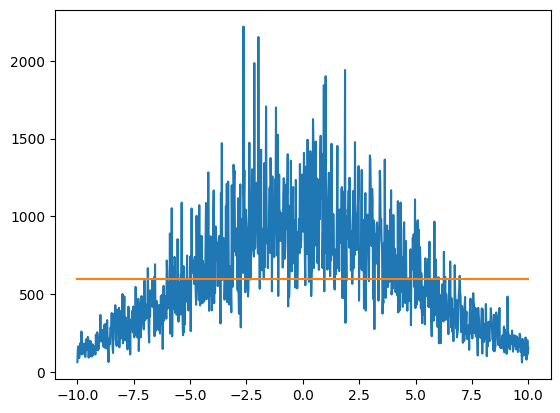

In [3]:
#parameters = {**PARAMETERS, **parameters}

# Initialize variables
variables = initialization(PARAMETERS)
plt.plot(variables.xData, variables.data, label = "Data")
plt.plot(variables.xIndu, variables.fIndu, label = "Ground")

In [4]:
def GibbsSampler(variables):

    alphaVect = []
    alphaVect.append(variables.alpha)

    curveVect = []
    curveVect.append(variables.fIndu)

    pVect = []

    for i in range(50):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = curveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)
    
    for i in range(50):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = fineCurveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)

    for i in range(50):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = finerCurveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)
    
    return variables, alphaVect, curveVect, pVect

variables, alphaVect, curveVect, pVect = GibbsSampler(variables)


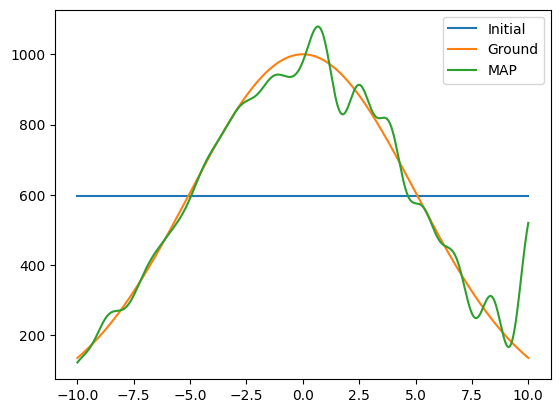

In [5]:
fFine = variables.cInduFine.T @ variables.cInduInduInv @ curveVect[pVect.index(max(pVect))]

plt.plot(variables.xIndu, curveVect[0], label = "Initial")
plt.plot(variables.xData, variables.grndY, label = "Ground")
plt.plot(variables.xFine, fFine, label = "MAP")
plt.legend()

In [6]:
100 * np.abs((alphaVect[pVect.index(max(pVect))] - variables.grndAlpha)/variables.grndAlpha)


21.195355918649703

In [7]:
pVect.index(max(pVect))

138